In [6]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [7]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [8]:
x_train = np.load('../training_dataset_homework2/x_train.npy')
y_train = np.load('../training_dataset_homework2/y_train.npy')

In [9]:
x_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [10]:
x_train = x_train / 255

((1578, 36, 6), (1578,), (851, 36, 6), (851,))

In [14]:
x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, random_state=seed, test_size=.35
)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

,0,1,2,3,4,5
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,14.348565,45.351667,22.758908,10.290633,8.321046,6.535606
std,16.054875,7.776298,26.375143,20.025119,22.504214,30.239977
min,-25.010000,12.038000,-48.315000,-51.789000,-32.670000,-88.783000
25%,5.612500,43.344000,17.390750,9.766675,-3.223025,-9.156225
50%,13.376000,45.915500,31.450000,18.506000,3.054700,4.144300
75%,24.986500,48.198750,38.429750,21.553750,14.850000,29.746250
max,40.229000,58.559000,57.518000,27.014000,81.270000,55.674000


In [403]:
test = pd.DataFrame(x_train[1].copy())
test.describe()

,0,1,2,3,4,5
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.004850,0.009607,0.027971,0.046199,0.038605,0.039229
std,0.013711,0.019255,0.064159,0.112527,0.101491,0.113859
min,-0.017275,-0.008124,-0.006560,-0.011998,-0.029769,-0.046000
25%,-0.004134,-0.002153,-0.001402,-0.001270,-0.001896,-0.007318
50%,0.001935,0.003474,0.003306,0.004058,0.006171,0.008643
75%,0.011117,0.012211,0.030049,0.029693,0.025965,0.030820
max,0.044184,0.077286,0.261478,0.492353,0.471333,0.487294


In [404]:
clean_test = test.copy()
eps = 0.001
#clean_test[5] = np.log(clean_test[5] + eps)

clean_test[5]

0     0.389157
1     0.487294
2     0.296510
3     0.053498
4     0.091682
5     0.059137
6     0.045757
7     0.054518
8    -0.001757
9     0.019815
10    0.009135
11   -0.043533
12   -0.023071
13    0.007971
14   -0.031103
15   -0.026434
16    0.012191
17    0.009580
18   -0.046000
19   -0.009190
20    0.008150
21   -0.011631
22   -0.005702
23    0.025666
24   -0.005442
25    0.009578
26    0.016405
27   -0.037142
28   -0.019064
29   -0.006695
30   -0.000554
31    0.029332
32    0.012868
33    0.035286
34    0.008074
35   -0.002054
Name: 5, dtype: float64

In [405]:
label_mapping = {
    "Wish": 0,
    "Another": 1,
    "Comfortably": 2,
    "Money": 3,
    "Breathe":4,
    "Time":5,
    "Brain":6,
    "Echoes":7,
    "Wearing":8,
    "Sorrow":9,
    "Hey":10,
    "Shine":11
}

In [406]:
# Convert the sparse labels to categorical values
y_train_categorical = tfk.utils.to_categorical(y_train)
y_test_categorical = tfk.utils.to_categorical(y_test)
x_train.shape, y_train_categorical.shape, x_test.shape, y_test_categorical.shape

((1578, 36, 6), (1578, 12), (851, 36, 6), (851, 12))

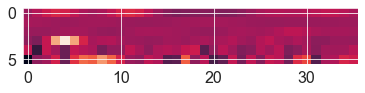

In [407]:
index = 100
image = x_train[index]

plt.figure(figsize=(6, 6))
plt.imshow(image.T)
plt.show()

In [408]:
y_dataframe = pd.DataFrame(y_train)

y_dataframe.columns = ['class']

y_dataframe = y_dataframe.groupby('class').size().to_frame().reset_index().set_index("class")
y_dataframe

,0
class,
0,25
1,85
2,158
3,241
4,38
5,104
6,201
7,45
8,76


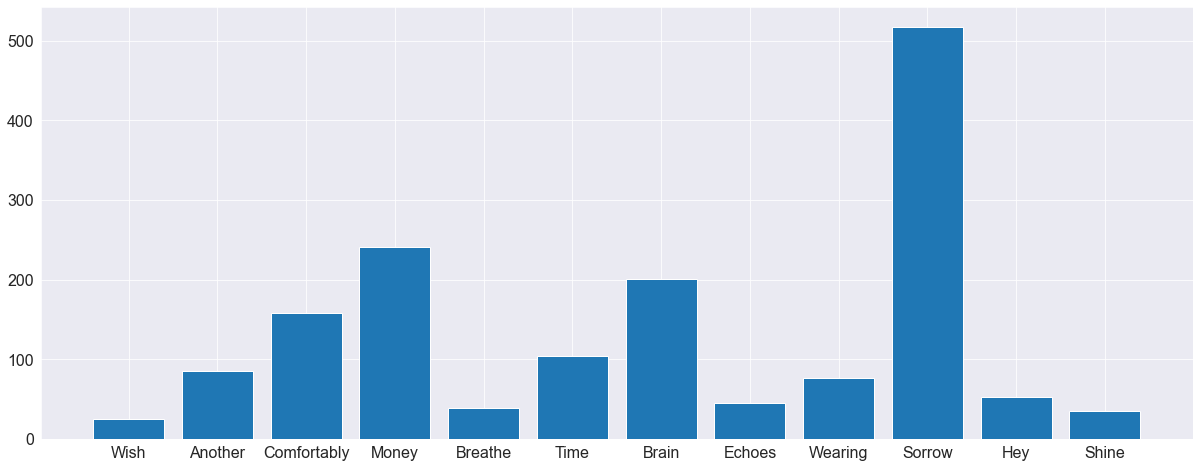

In [409]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_axes([0, 0, 1, 1])
classnames = label_mapping.keys()
values = y_dataframe[0].values
ax.bar(classnames, values)

plt.show()

In [418]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    None,
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights, 0))

class_weights

{0: 1.0,
 1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0,
 10: 1.0,
 11: 1.0}

In [411]:
input_shape = x_train.shape[1:]
classes = y_train_categorical.shape[-1]
batch_size = 256
epochs = 200

In [412]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(256, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(256)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [413]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_24 (LSTM)              (None, 36, 256)           269312    
                                                                 
 lstm_25 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 256)               65792     
                                                                 
 dense_28 (Dense)            (None, 12)                3084      
                                                                 
Total params: 863,500
Trainable params: 863,500
Non-trainable

In [414]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train_categorical,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    class_weight=class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/200


2022-12-12 20:31:41.366792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 20:31:41.796012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 20:31:42.058367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 20:31:42.720663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 20:31:43.225297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 3.8458 - accuracy: 0.0732

2022-12-12 20:31:46.228735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 20:31:46.391142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 20:31:46.825417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 9s 692ms/step - loss: 3.8458 - accuracy: 0.0732 - val_loss: 2.4969 - val_accuracy: 0.1139 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 1s 192ms/step - loss: 3.0665 - accuracy: 0.1049 - val_loss: 2.0554 - val_accuracy: 0.3608 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 1s 165ms/step - loss: 2.8613 - accuracy: 0.2261 - val_loss: 2.3069 - val_accuracy: 0.1329 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 1s 173ms/step - loss: 2.7335 - accuracy: 0.1141 - val_loss: 2.1065 - val_accuracy: 0.1392 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 1s 196ms/step - loss: 2.6382 - accuracy: 0.1268 - val_loss: 2.0211 - val_accuracy: 0.1582 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 1s 201ms/step - loss: 2.5438 - accuracy: 0.1514 - val_loss: 2.0873 - val_accuracy: 0.1709 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 1s 164ms/step - loss: 2.4460 - accura

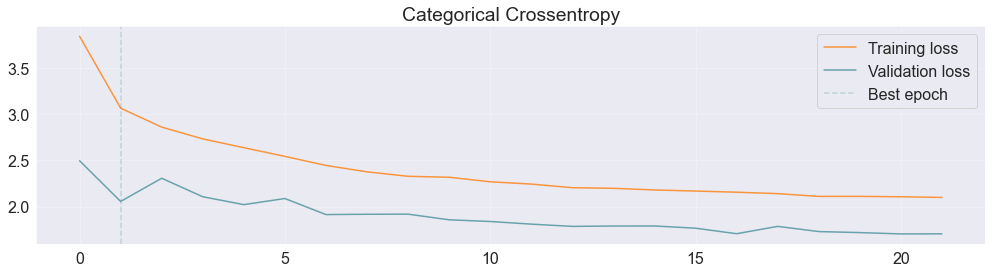

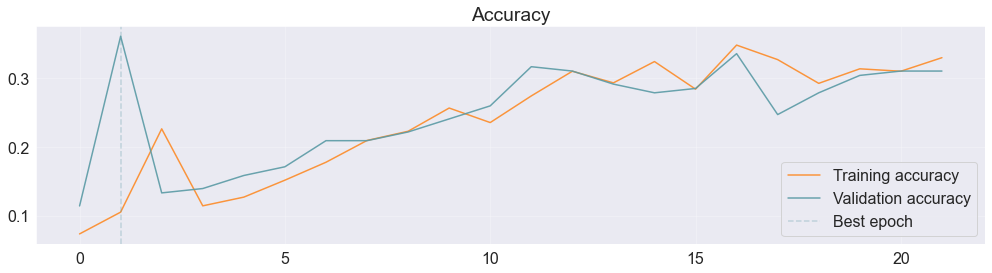

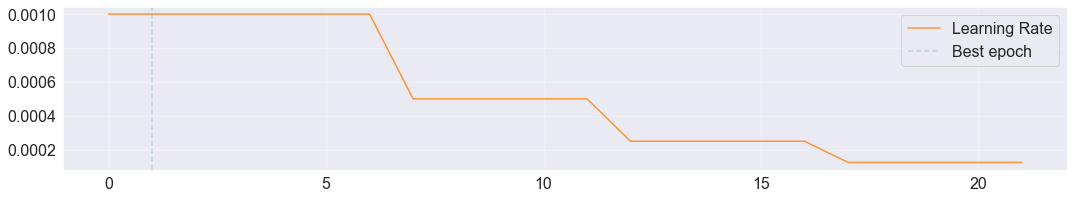

In [415]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [144]:
model.save('best_model')

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


In [416]:
predictions = model.predict(x_test)
predictions.shape

2022-12-12 20:32:51.652283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 20:32:51.774637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 20:32:52.001770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 3s 60ms/step


(851, 12)

Accuracy: 0.3255
Precision: 0.1378
Recall: 0.126
F1: 0.0786


/Users/federicobono/opt/anaconda3/envs/DeepLearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


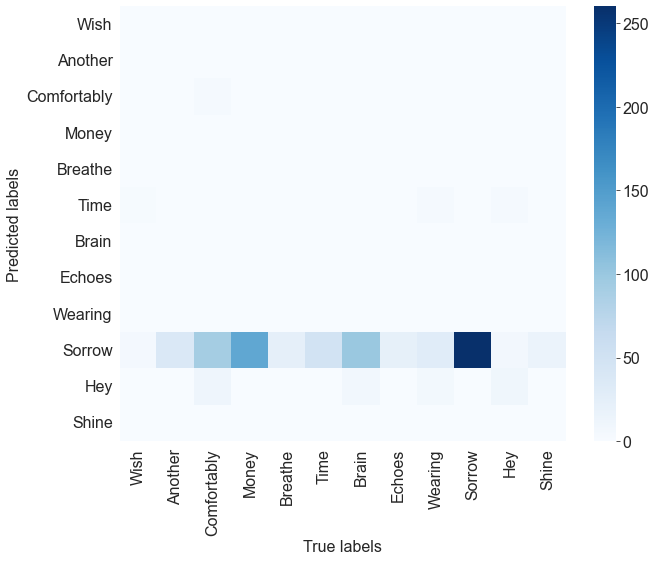

In [417]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test_categorical, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test_categorical, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()